<a href="https://colab.research.google.com/github/KamilShape/building_style_recognition/blob/main/computer_vision_my_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Main goal of this project is to recgnize buildings architecture style. 

In [30]:
import requests
from bs4 import BeautifulSoup
from PIL import Image
from io import BytesIO
import random
import os
import numpy as np


### Connecting to google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


### Getting Images

In [ ]:
styles = ['greek-architecture', 'gothic-architecture', 'baroque-architecture', 'victorian-architecture', 'modern-architecture']

In [ ]:
def parse_url(content):
  soup = BeautifulSoup(content, 'html.parser')
  print(content)
  imgs = soup.find_all('img', {'class': 'grid-image'})
  return [img['src'] for img in imgs]

In [ ]:
def get_page(style, page):
  url = f'https://www.freeimages.com/search/{style}/{page}'
  #for page in range(1, page + 1):
  #url = url
  print(url)
  try:
    response = requests.get(url)
    content = response.content
    print(content)
    return content
  except:
    print('Error! Wrong url.')

In [ ]:
def get_image(photo_url, path, file_name, style):
  image_response = requests.get(photo_url)
  image_content = image_response.content
  img = Image.open(BytesIO(image_content))
  if img.mode == 'RGB':
    os.makedirs(f'{path}/{style}', exist_ok=True)
    img.save(f'{path}/{style}/{file_name}', 'png')

In [ ]:
train_path = 'drive/MyDrive/architecture_photos/data/train'

In [ ]:
def get_photos(style, page, path):
  content = get_page(style, page)
  images = parse_url(content)
  for image in images:
    if len(image) > 5:
      file_name = image.split('/')[-1]
      get_image(image, train_path, file_name, style)


In [ ]:
#DOWNLOADING ALL PHOTOS
pages = 3
for style in styles:
  for page in range(1,pages +1):
    get_photos(style, page, train_path)

https://www.freeimages.com/search/greek-architecture/1
b'\n\n\n\n<!DOCTYPE html>\n<html lang="en">\n\n<head>\n    <meta charset="UTF-8">\n    <meta http-equiv="X-UA-Compatible" content="IE=edge">\n    <meta name="viewport" content="width=device-width, initial-scale=1.0">\n\n    <meta name="robots" content="max-image-preview:large">\n\n    <link rel="alternate" hreflang="en" href="https://www.freeimages.com/search/greek-architecture/1" />\n<link rel="alternate" hreflang="de" href="https://www.freeimages.com/de/search/greek-architecture/1" />\n<link rel="alternate" hreflang="es" href="https://www.freeimages.com/es/search/greek-architecture/1" />\n<link rel="alternate" hreflang="fr" href="https://www.freeimages.com/fr/search/greek-architecture/1" />\n<link rel="alternate" hreflang="it" href="https://www.freeimages.com/it/search/greek-architecture/1" />\n<link rel="alternate" hreflang="ja" href="https://www.freeimages.com/jp/search/greek-architecture/1" />\n<link rel="alternate" hreflang="

In [ ]:
for style in styles:
  print(len(os.listdir(f'{train_path}/{style}')))

179
172
132
91
177


### Test and train datasets

In [ ]:
test_path = 'drive/MyDrive/architecture_photos/data/test'

In [ ]:
os.makedirs(f'{test_path}')

In [ ]:
def create_test_set(styles, train_path, test_path, set_size):
  for style in styles:
    files_folder = os.listdir(f'{train_path}/{style}')
    for n in range(0, round(len(files_folder)*set_size)+1):
      files_folder = os.listdir(f'{train_path}/{style}')
      photo_number = np.random.randint(len(files_folder))
      os.makedirs(f'{test_path}/{style}', exist_ok=True)
      os.replace(f'{train_path}/{style}/{files_folder[photo_number]}', f'{test_path}/{style}/{files_folder[photo_number]}')

In [ ]:
create_test_set(styles, train_path, test_path, 0.15)

### Model 

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow import keras

In [ ]:
img_height = 64
img_width = 64
batch_size = 30

In [31]:
train_ds = keras.utils.image_dataset_from_directory(
    train_path,
    validation_split = 0.2,
    seed=0,
    subset='training',
    image_size = (img_height, img_width),
    batch_size = batch_size,
    label_mode = 'categorical')

val_ds = keras.utils.image_dataset_from_directory(
    train_path,
    validation_split = 0.2,
    seed=0,
    subset='validation',
    image_size = (img_height, img_width),
    batch_size = batch_size,
    label_mode = 'categorical')

Found 645 files belonging to 5 classes.
Using 516 files for training.
Found 645 files belonging to 5 classes.
Using 129 files for validation.


In [35]:
model = Sequential()
model.add(layers.Rescaling(1./255))

model.add(layers.Conv2D(64, (5,5), padding='same', activation='relu'))
model.add(layers.MaxPool2D((2,2)))
model.add(layers.RandomRotation(factor = (-0.2, 0.3), fill_mode='reflect', interpolation='bilinear',))

model.add(layers.Conv2D(32, (5,5), padding='same', activation='relu'))
model.add(layers.MaxPool2D((2,2)))
model.add(layers.RandomRotation(factor = (-0.2, 0.3), fill_mode='reflect', interpolation='bilinear',))

model.add(layers.MaxPool2D((2,2)))
model.add(layers.Dropout(rate=0.1))
model.add(layers.RandomRotation(factor = (-0.2, 0.3), fill_mode='reflect', interpolation='bilinear',)) 

model.add(layers.Conv2D(16, (5,5), padding='same', activation='relu'))
model.add(layers.MaxPool2D((2,2)))
model.add(layers.Dropout(rate=0.1))

model.add(layers.Conv2D(8, (5,5), padding='same', activation='relu'))
model.add(layers.MaxPool2D((2,2)))
model.add(layers.Dropout(rate=0.1))

model.add(layers.Flatten())
model.add(layers.Dense(5, activation='softmax'))

In [33]:
model.compile(optimizer='Adam',
              loss='categorical_crossentropy',
              metrics = ['accuracy'])

In [34]:
history = model.fit(
    train_ds,
    validation_data = val_ds,
    epochs = 70,
    batch_size = batch_size)

Epoch 1/70
18/18 [==============================] - 16s 788ms/step - loss: 1.6111 - accuracy: 0.2132 - val_loss: 1.5827 - val_accuracy: 0.2326
Epoch 2/70
18/18 [==============================] - 15s 809ms/step - loss: 1.5824 - accuracy: 0.2500 - val_loss: 1.5788 - val_accuracy: 0.2171
Epoch 3/70
18/18 [==============================] - 15s 798ms/step - loss: 1.5885 - accuracy: 0.2403 - val_loss: 1.5798 - val_accuracy: 0.2403
Epoch 4/70
18/18 [==============================] - 14s 780ms/step - loss: 1.5909 - accuracy: 0.2229 - val_loss: 1.5717 - val_accuracy: 0.2403
Epoch 5/70
18/18 [==============================] - 15s 814ms/step - loss: 1.5889 - accuracy: 0.2442 - val_loss: 1.5717 - val_accuracy: 0.2093
Epoch 6/70
18/18 [==============================] - 15s 808ms/step - loss: 1.5875 - accuracy: 0.2791 - val_loss: 1.5833 - val_accuracy: 0.2791
Epoch 7/70
18/18 [==============================] - 13s 689ms/step - loss: 1.5711 - accuracy: 0.2752 - val_loss: 1.5555 - val_accuracy: 0.2713

In [ ]:
history.history

{'loss': [1.6112442016601562,
  1.584405541419983,
  1.582985281944275,
  1.5785801410675049,
  1.563604474067688,
  1.560720443725586,
  1.5493249893188477,
  1.537377119064331,
  1.5459073781967163,
  1.5125676393508911,
  1.4716589450836182,
  1.4875633716583252,
  1.4145655632019043,
  1.418646216392517,
  1.3852769136428833,
  1.3615806102752686,
  1.3185075521469116,
  1.3295882940292358,
  1.271316647529602,
  1.2675665616989136,
  1.219850778579712,
  1.201093316078186,
  1.1556881666183472,
  1.1812222003936768,
  1.1161643266677856,
  1.127439260482788,
  1.06220543384552,
  0.9885735511779785,
  0.995163083076477,
  0.9913090467453003,
  0.8997952342033386,
  0.8644973635673523,
  0.8915684819221497,
  0.912296712398529,
  0.8218312859535217,
  0.8039182424545288,
  0.7358413934707642,
  0.7249990105628967,
  0.6880654692649841,
  0.721991777420044,
  0.7434138059616089,
  0.6640588641166687,
  0.6270761489868164,
  0.6642125844955444,
  0.5675697326660156,
  0.5987508893013

In [ ]:
accuracy = history.history.get('accuracy')
val_accuracy = history.history.get('val_accuracy')

### Charts

In [ ]:
import matplotlib.pyplot as plt

Text(0.5, 0, 'Epochs')

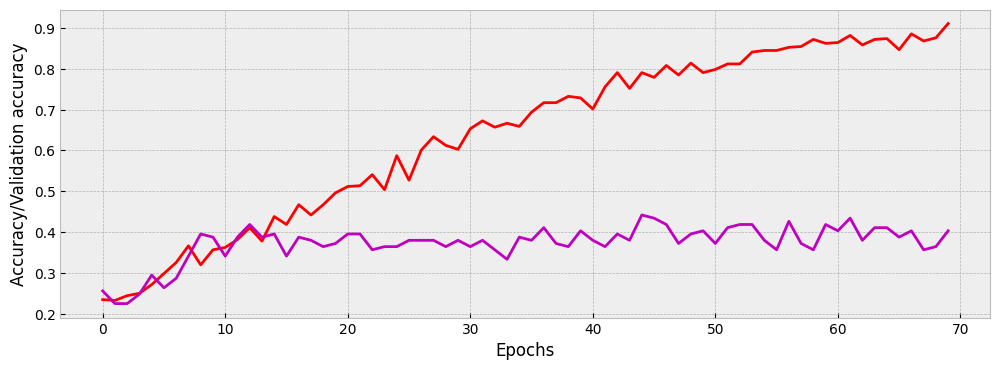

In [ ]:
plt.style.use('bmh')
fig, ax = plt.subplots(figsize = (12,4))
plt.plot(accuracy, label='Accuracy', color='r')
plt.plot(val_accuracy, label='Validation accuracy', color='m')
ax.legend
ax.set_ylabel('Accuracy/Validation accuracy')
ax.set_xlabel('Epochs')